In [1]:
#python 2 and 3 comptibility
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import json
import io
import gzip
import base64
from astropy.io import fits
import matplotlib.pylab as plt
import pickle as pkl
import numpy as np
%matplotlib inline

data_path = '/home/ereyes/Alerce/ZTF_7_18'

#with open('/home/asceta/LRPpaper/datasets/ZTF/reals.pkl', 'rb') as f:
#    reals = pkl.load(f)
#with open('/home/asceta/LRPpaper/datasets/ZTF/bogus.pkl', 'rb') as f:
#    bogus = pkl.load(f)
    
#print('Number of reals: %d' %len(reals))
#print('Number of bogus: %d' %len(bogus))
%config InlineBackend.figure_format = 'retina'

In [2]:
def json2list(path):
    #load json
    with open(path, "r") as f:
        dataset = json.load(f)
    
    samples_list = []
    for i in range(len(dataset['query_result'])):

        channels = []
        for k, imstr in enumerate(['Template', 'Science', 'Difference']):
            stamp = dataset['query_result'][i]['cutout'+imstr]['stampData']
            stamp = base64.b64decode(stamp["$binary"].encode())

            with gzip.open(io.BytesIO(stamp), 'rb') as f:
                with fits.open(io.BytesIO(f.read())) as hdul:
                    img = hdul[0].data
                    channels.append(img)
        samples_list.append(np.array(channels))
    return samples_list

In [3]:
def check_samples_shapes(samples):
    miss_shaped_sample_idx = []
    for i in range(len(samples)):
        sample = samples[i]
        if sample.shape[0]!=3 or sample.shape[1]!=63 or sample.shape[2]!=63:
            #print("sample %i of shape %s" %(i,str(sample.shape)))
            miss_shaped_sample_idx.append(i)
    return miss_shaped_sample_idx

#misshaped_reals = check_samples_shapes(reals)
#misshaped_bogus = check_samples_shapes(bogus)
 
#print('Number of misshaped reals: %d' %len(misshaped_reals))
#print('Number of misshaped bogus: %d' %len(misshaped_bogus))

In [4]:
#TODO padding non trivial by determining center

def clean_misshaped(samples):
    miss_shaped_sample_idx = check_samples_shapes(samples)
    print('%d misshaped samples removed' %len(miss_shaped_sample_idx))
    for index in sorted(miss_shaped_sample_idx, reverse=True):
        samples.pop(index)
    return np.moveaxis(np.array(samples), 1, -1)

#reals_clean = clean_misshaped(reals)
#bogus_clean = clean_misshaped(bogus)

In [5]:
def crop_at_center(sample_numpy, cropsize=21):
    center = int((sample_numpy.shape[1]-1)/2)
    crop_side = int((cropsize-1)/2)
    crop_begin = center-crop_side
    crop_end = center+crop_side+1
    #print(center)
    #print(crop_begin, crop_end)
    return sample_numpy[:,crop_begin:crop_end,crop_begin:crop_end,:]

#reals_croped = crop_at_center(clean_misshaped(reals))
#bogus_croped = crop_at_center(clean_misshaped(bogus))

In [6]:
def zero_fill_nans(samples_numpy):
    samples_with_nan_idx = []
    for i in range(samples_numpy.shape[0]):
        if(np.isnan(samples_numpy[i,...]).any()):
            samples_with_nan_idx.append(i)
    print('%d samples with NaNs' %len(samples_with_nan_idx))
    return np.nan_to_num(samples_numpy)

#reals_croped_padded = zero_fill_nans(crop_at_center(clean_misshaped(reals)))
#bogus_croped_padded = zero_fill_nans(crop_at_center(clean_misshaped(bogus)))

In [7]:
def remove_nans(samples_numpy):
    samples_no_nan = []
    count = 0
    for i in range(samples_numpy.shape[0]):
        if not (np.isnan(samples_numpy[i,...]).any()):
            samples_no_nan.append(samples_numpy[i,...])
    #print('%d samples with NaNs' %len(samples_with_nan_idx))
    return np.array(samples_no_nan)

#reals_croped_padded = zero_fill_nans(crop_at_center(clean_misshaped(reals)))
#bogus_croped_padded = zero_fill_nans(crop_at_center(clean_misshaped(bogus)))

In [8]:
#normalice each channel individually. Every channel of every sample will be 0-1 normalized
def normalize_01(samples_numpy):
    for i in range(samples_numpy.shape[0]):
        for j in range(samples_numpy.shape[3]):
            sample = samples_numpy[i,:,:,j]
            normalized_sample = (sample-np.min(sample))/np.max(sample-np.min(sample))
            samples_numpy[i,:,:,j] = normalized_sample
    return samples_numpy



In [9]:
def print_sample(img):
    fig = plt.figure()
    for k, imstr in enumerate(['Template', 'Science', 'Difference']):
        ax = fig.add_subplot(1,3,k+1)
        ax.axis('off')
        ax.set_title(imstr)
        ax.matshow(img[...,k])
        

# preprocessing

In [10]:
reals = remove_nans(clean_misshaped(json2list(data_path+'/broker_reals.json')))
#bogus_croped_padded_norm = normalize_01(zero_fill_nans(crop_at_center(clean_misshaped(json2list(data_path+'/broker_bogus.json')))))

118 misshaped samples removed


In [11]:
reals.shape

(6054, 63, 63, 3)

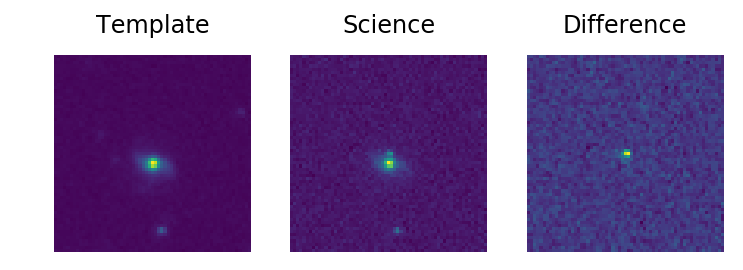

In [12]:
print_sample(reals[1050,...])

In [13]:
np.max(reals)

67038.445

In [14]:
np.min(reals)

-6394.199

In [15]:
np.mean(reals[...,2])

0.82452476

# PSFS

In [24]:
def get_PSF(diff_reals, N=1.5):
    sigma = np.std(diff_reals, axis=(1,2))
    N_sigma = N*sigma
    PSF = diff_reals*(diff_reals>N_sigma.reshape(diff_reals.shape[0],1,1))
    return PSF, sigma

In [25]:
PSFs, sigmas = get_PSF(reals[...,2])

In [28]:
(sigmas>0).sum()

6054

In [20]:
def print_sample_PSF(img):
    fig = plt.figure()
    for k, imstr in enumerate(['Template', 'Science', 'Difference', 'PSF']):
        ax = fig.add_subplot(1,4,k+1)
        ax.axis('off')
        ax.set_title(imstr)
        ax.matshow(img[...,k])
def print_sample_PSF_diff(img):
    fig = plt.figure()
    for k, imstr in enumerate(['Difference', 'PSF']):
        ax = fig.add_subplot(1,2,k+1)
        ax.axis('off')
        ax.set_title(imstr)
        ax.matshow(img[...,k+2])

In [21]:
PSFs = get_PSF(get_PSF(get_PSF(get_PSF(get_PSF(get_PSF(reals[...,2]))))))

In [22]:
reals_plus_PSF = np.append(reals, PSFs.reshape(PSFs.shape[0],PSFs.shape[1],PSFs.shape[2],1), axis=3)

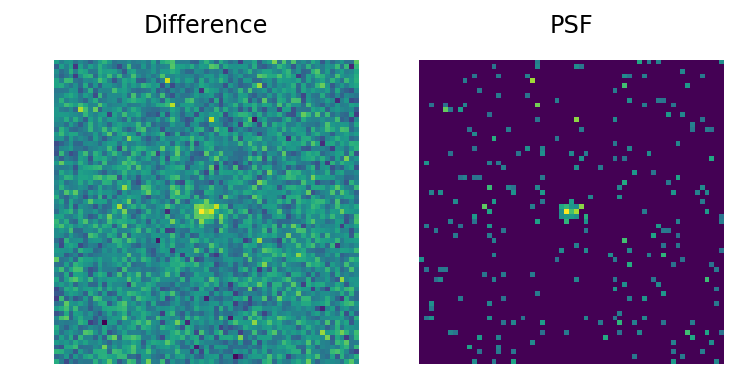

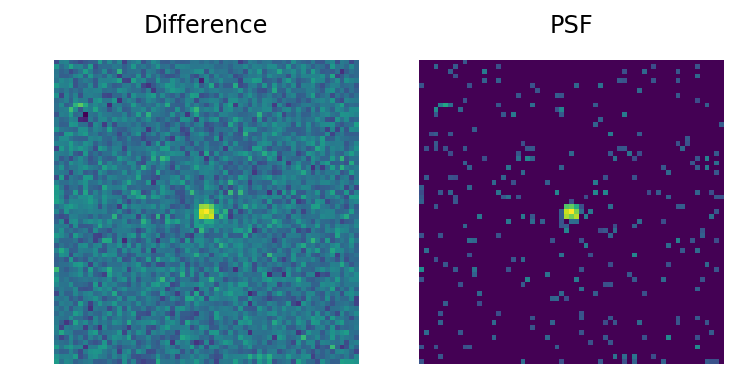

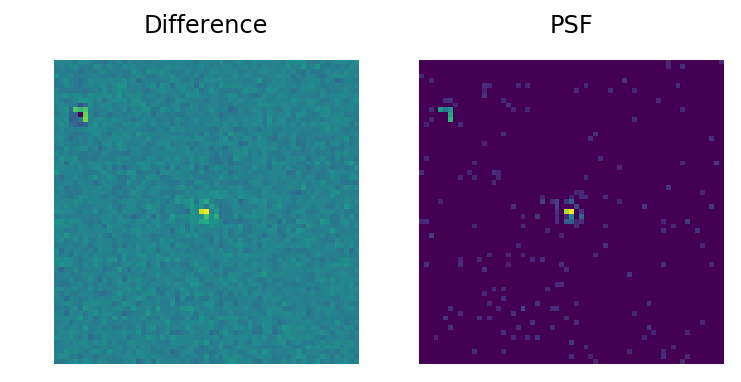

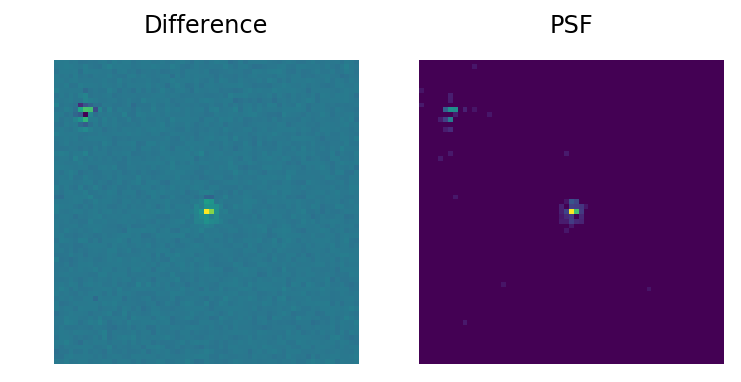

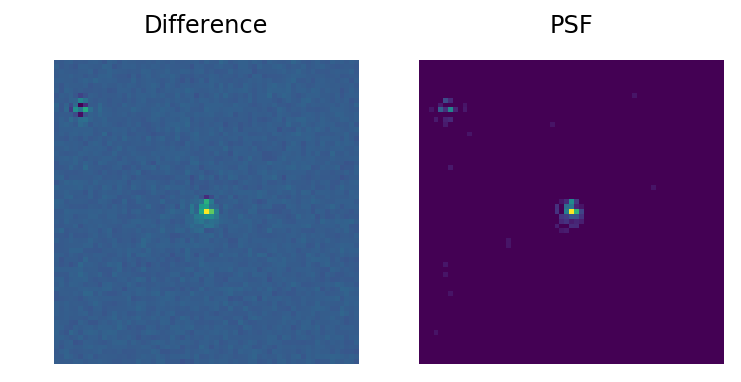

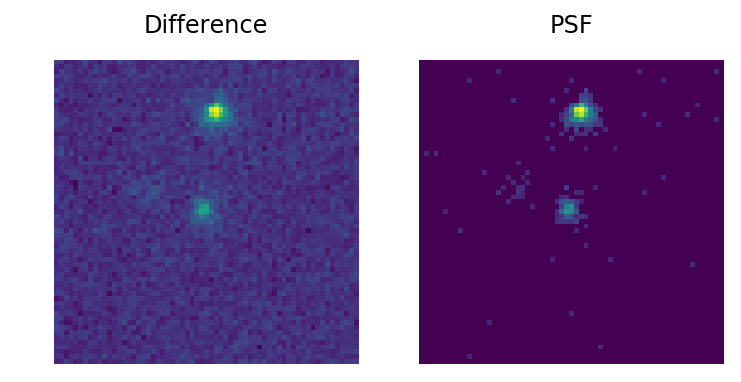

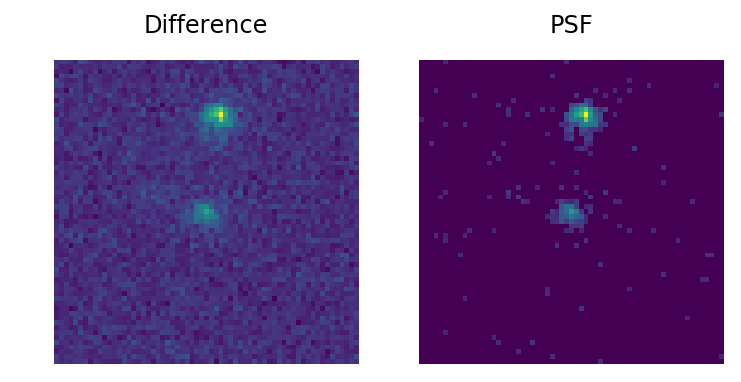

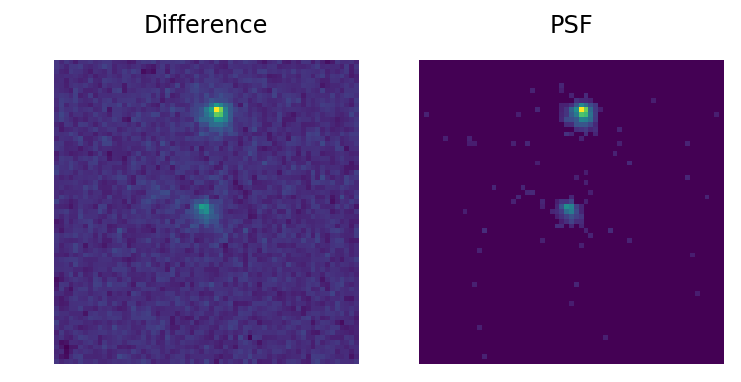

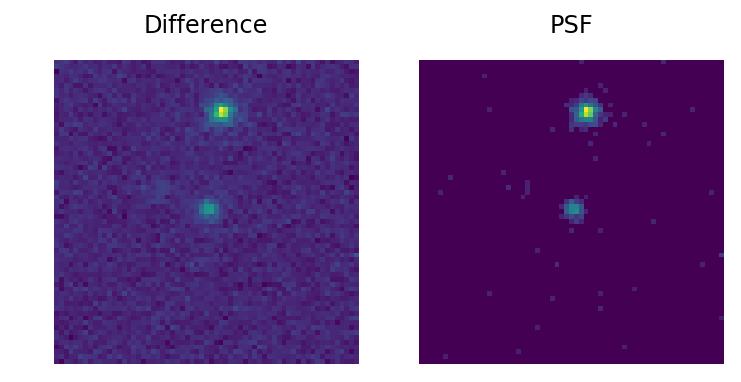

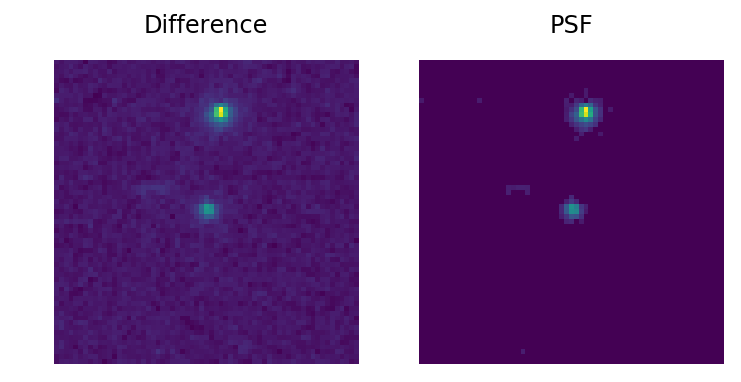

In [23]:
for i in range(10):
    print_sample_PSF_diff(reals_plus_PSF[i,...])

In [199]:
psf1 = get_PSF(reals[...,2])
psf2 = get_PSF(get_PSF(get_PSF(get_PSF(get_PSF(reals[...,2])))))

In [200]:
(psf1-psf2).mean()

0.000102316204